# Exploratory analyses of the dataset of the single nuclei
---

## 0. Environmental setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import describe
import sys
import os
import tifffile
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance_matrix
from tqdm import tqdm
from scipy.stats import ttest_ind, ranksums
import pickle

sys.path.append("../../../..")

from src.utils.basic.io import get_file_list

In [2]:
def get_file_name_list(absolute_path_list):
    file_name_list = []
    for path in file_path_list:
        file_name_list.append(os.path.split(path)[1])
    return file_name_list

In [3]:
def get_average_histogram_for_target(
    target,
    metadata,
    file_path_list,
    gene_symbol_col="gene_symbol",
    image_file_col="image_file",
    n_nuclei=300,
    random_state=1234,
):
    file_name_list = get_file_name_list(file_path_list)
    target_nuclei_image_locs = np.array(
        metadata.loc[metadata[gene_symbol_col] == target, image_file_col]
    )
    np.random.seed(random_state)
    nuclei_idc = np.random.choice(len(target_nuclei_image_locs), size=n_nuclei)
    histograms = []
    for i in range(len(nuclei_idc)):
        image = tifffile.imread(
            file_path_list[file_name_list.index(target_nuclei_image_locs[nuclei_idc[i]])]
        )
        image = image.ravel()
        histogram = np.histogram(image, bins=256)[0]
        histogram = histogram / histogram.sum()
        histograms.append(histogram)
    return histograms


def get_average_histograms(
    metadata,
    file_path_list,
    gene_symbol_col="gene_symbol",
    image_file_col="image_file",
    n_nuclei=300,
    random_state=1234,
):
    targets = np.unique(metadata.loc[:, gene_symbol_col])
    profile_dict = {}
    for i in tqdm(range(len(targets)), desc="Computing histograms for targets"):
        target= targets[i]
        profile_dict[target] = get_average_histogram_for_target(
            target=target,
            metadata=metadata,
            file_path_list=file_path_list,
            gene_symbol_col=gene_symbol_col,
            image_file_col=image_file_col,
            n_nuclei=n_nuclei,
            random_state=random_state
        )
    return profile_dict

In [4]:
def run_meanshift_screen(profile_dict, control, test="t"):
    targets = list(profile_dict.keys())
    profile_mean_dict = {}

    for target in targets:
        profile_means = []
        for histogram in profile_dict[target]:
            profile_means.append((histogram * np.array(list(range(256)))).sum())
        profile_mean_dict[target] = np.array(profile_means)
        
    control_means = profile_mean_dict[control]
    
    control_mean = np.repeat(control_means.mean(), len(targets)-1)
    p_values = []
    test_means = []
    target_names = []
    for target in targets:
        if target != control:
            target_names.append(target)
            target_means = profile_mean_dict[target]
            test_means.append(target_means.mean())
            if test == "t":
                p_values.append(ttest_ind(control_means, target_means, equal_var=False)[1])
            elif test == "wilcox":
                p_values.append(ranksums(control_means, target_means)[1])
            else:
                print("Unknown test...")
                break
    screen_results = pd.DataFrame(control_mean, columns=[control+"_mean"])
    screen_results["target_mean"] = test_means
    screen_results["p_value"] = p_values
    screen_results.index = target_names
    screen_results["fwer"] = np.clip(np.array(screen_results["p_value"]) * len(screen_results),0,1)
    return screen_results.sort_values("p_value"), profile_mean_dict

In [5]:
def run_modeshift_screen(profile_dict, control, test="t"):
    targets = list(profile_dict.keys())
    profile_mode_dict = {}

    for target in targets:
        profile_modes = []
        for histogram in profile_dict[target]:
            # Exclude background peak
            profile_modes.append(np.argmax(histogram[1:])+1)
        profile_mode_dict[target] = np.array(profile_modes)
        
    control_modes = profile_mode_dict[control]
    
    control_mode = np.repeat(control_modes.mean(), len(targets)-1)
    p_values = []
    test_modes = []
    target_names = []
    for target in targets:
        if target != control:
            target_names.append(target)
            target_modes = profile_mode_dict[target]
            test_modes.append(target_modes.mean())
            if test == "t":
                p_values.append(ttest_ind(control_modes, target_modes, equal_var=False)[1])
            elif test == "wilcox":
                p_values.append(ranksums(control_modes, target_modes)[1])
            else:
                print("Unknown test...")
                break
    screen_results = pd.DataFrame(control_mode, columns=[control+"_mode"])
    screen_results["target_mode"] = test_modes
    screen_results["p_value"] = p_values
    screen_results.index = target_names
    screen_results["fwer"] = np.clip(np.array(screen_results["p_value"]) * len(screen_results),0,1)
    return screen_results.sort_values("p_value"), profile_mode_dict

In [6]:
def get_average_profiles(profile_dict):
    avg_profile_dict = {}
    for target in profile_dict.keys():
        avg_profile_dict[target] = np.array(profile_dict[target]).mean(axis=0)
    return avg_profile_dict

## 1. Padding size decision

The first step after segmenting the individual nuclei is to decide on the padding to make all nuclei of equal size for our following workflows.

To this end, we look at the empirical distribution of the width and heights of the bounding boxes of all identified nuclei. The corresponding information are available in a the metadata that is generated when cropping the segmented images.

In [7]:
crop_nuclei_metadata = pd.read_csv(
    "../../../../data/experiments/rohban/images/preprocessing/full_pipeline/padded_nuclei_metadata.csv.gz",
    index_col=0,
)

In [8]:
crop_nuclei_metadata.head()

,plate,well,image_file,gene_id,gene_symbol,is_landmark,allele,expr_vec,toxicity,ie_blast,...,minor_axis_length,major_axis_length,aspect_ratio,aspect_ratio_cluster,nuclei_count_image,slide_image_name,aspect_ratio_cluster_ratio,centroid_0,centroid_1,allele_symbol
0,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,15.474579,35.755476,0.432789,1,53,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,0.528302,17.675294,19.835294,EIF4E_WT.2
1,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,16.074259,48.342010,0.332511,1,53,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,0.528302,28.882645,273.150413,EIF4E_WT.2
2,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,24.256958,35.030138,0.692460,0,53,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,0.528302,149.476762,1002.848576,EIF4E_WT.2
3,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,27.689881,51.502812,0.537638,1,53,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,0.528302,250.939748,108.973921,EIF4E_WT.2
4,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,26.587002,32.592086,0.815750,0,53,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,0.528302,252.834328,913.795522,EIF4E_WT.2


<Figure size 432x288 with 0 Axes>

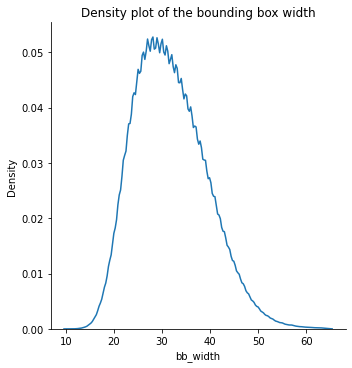

In [9]:
plt.figure()
bb_width_density = sns.displot(crop_nuclei_metadata, x="bb_width", kind="kde")
plt.title("Density plot of the bounding box width")
plt.show()

<Figure size 432x288 with 0 Axes>

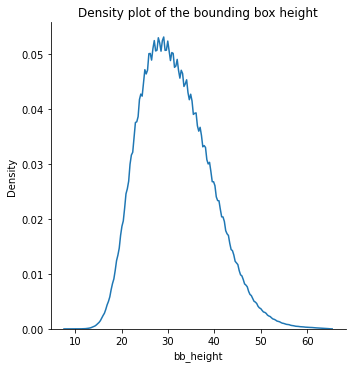

In [10]:
plt.figure()
bb_width_density = sns.displot(crop_nuclei_metadata, x="bb_height", kind="kde")
plt.title("Density plot of the bounding box height")
plt.show()

In [11]:
fitted_nuclei = np.sum((np.array(crop_nuclei_metadata["bb_width"])<=64).astype(int) * (np.array(crop_nuclei_metadata["bb_height"])<=64).astype(int))
fitted_nuclei

1063641

In [12]:
len(crop_nuclei_metadata) - fitted_nuclei

0

---

## 2. Final single nuclei dataset (padded images)

### 2.1. General overview

Next, we will quickly provide some overview of the characteristics of the final dataset that we end up with after all preprocessing steps.

In [13]:
nuclei_metadata = pd.read_csv("../../../../data/experiments/rohban/images/preprocessing/full_pipeline/padded_nuclei_metadata.csv.gz",index_col=0)

/usr/share/miniconda3/envs/image2reg/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [14]:
nuclei_metadata.head()

,plate,well,image_file,gene_id,gene_symbol,is_landmark,allele,expr_vec,toxicity,ie_blast,...,open_closed,rnai_plate,site,type,virus_vol,timepoint,assay_well_role,bb_width,bb_height,gene_label
0,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,open,ORA11.12.13.18A,7,ORF OE,1,72H,Treated,33,21,60
1,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,open,ORA11.12.13.18A,7,ORF OE,1,72H,Treated,46,17,60
2,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,open,ORA11.12.13.18A,7,ORF OE,1,72H,Treated,31,29,60
3,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,open,ORA11.12.13.18A,7,ORF OE,1,72H,Treated,46,36,60
4,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,open,ORA11.12.13.18A,7,ORF OE,1,72H,Treated,32,27,60


In [15]:
len(nuclei_metadata)

1063641

The final dataset consists of 1,063,628 nuclei. Next, we look at the distribution of the counts of nuclei per target.

In [25]:
nuclei_metadata["gene_allele_name"] = np.apply_along_axis("_".join, 0, [np.array(nuclei_metadata["gene_symbol"]).astype(str), np.array(nuclei_metadata["allele"]).astype(str)])
c_targets = Counter(np.array(nuclei_metadata["gene_allele_name"]))

In [26]:
c_targets

Counter({'EIF4E_WT.2': 3106,
         'DKK1_WT': 3193,
         'ATF6_WT.1': 3072,
         'FURIN_WT.2': 2945,
         'MAPK8_WT.2': 3107,
         'CARD11_WT': 3317,
         'ATG16L1_WT': 3036,
         'TSC1_WT.2': 3484,
         'PAK1_WT.2': 3046,
         'XBP1_WT.3': 1609,
         'PRKAA1_WT.': 5711,
         'MAP3K9_WT': 2054,
         'IKBKE_WT.2': 2770,
         'TGFBR1_WT.': 8397,
         'XBP1_WT.2': 2881,
         'RIPK1_WT': 3561,
         'EMPTY_nan': 102376,
         'PSENEN_WT': 2751,
         'BRAF_WT.1': 3109,
         'DVL1_WT.2': 2453,
         'PER1_WT.1': 2777,
         'EGLN1_WT.2': 2953,
         'MOS_WT.2': 2980,
         'BMPR1B_WT.': 5604,
         'BRAF_WT.2': 3013,
         'Luciferase': 22754,
         'CCND1_WT.2': 3199,
         'DVL3_WT': 3186,
         'TBK1_WT.2': 3074,
         'PIK3R1_WT.': 5690,
         'PRKACA_WT.': 2380,
         'NOTCH1_WT.': 6330,
         'DEPTOR_WT.': 5771,
         'TRAF6_WT.1': 3371,
         'PRKCZ_K281': 2801,
      

<Figure size 432x288 with 0 Axes>

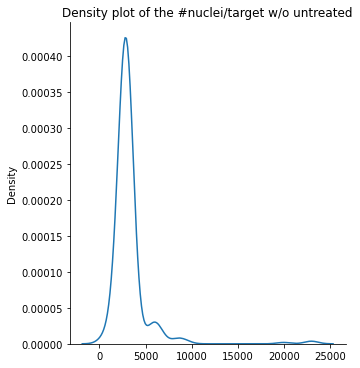

In [27]:
plt.figure()
n_target_density = sns.displot(sorted(np.array(list(c_targets.values())))[:-1], kind="kde")
plt.title("Density plot of the #nuclei/target w/o untreated")
plt.show()

In [146]:
c_targets = dict(sorted(c_targets.items(), key=lambda item: item[1]))
describe(list(c_targets.values())[:-4])

DescribeResult(nobs=190, minmax=(686, 11622), mean=4712.747368421053, variance=5517511.205680869, skewness=0.9740023554409513, kurtosis=0.610027120941556)

On average there are roughly 4173 single nuclei images 

In [28]:
c_targets

Counter({'EIF4E_WT.2': 3106,
         'DKK1_WT': 3193,
         'ATF6_WT.1': 3072,
         'FURIN_WT.2': 2945,
         'MAPK8_WT.2': 3107,
         'CARD11_WT': 3317,
         'ATG16L1_WT': 3036,
         'TSC1_WT.2': 3484,
         'PAK1_WT.2': 3046,
         'XBP1_WT.3': 1609,
         'PRKAA1_WT.': 5711,
         'MAP3K9_WT': 2054,
         'IKBKE_WT.2': 2770,
         'TGFBR1_WT.': 8397,
         'XBP1_WT.2': 2881,
         'RIPK1_WT': 3561,
         'EMPTY_nan': 102376,
         'PSENEN_WT': 2751,
         'BRAF_WT.1': 3109,
         'DVL1_WT.2': 2453,
         'PER1_WT.1': 2777,
         'EGLN1_WT.2': 2953,
         'MOS_WT.2': 2980,
         'BMPR1B_WT.': 5604,
         'BRAF_WT.2': 3013,
         'Luciferase': 22754,
         'CCND1_WT.2': 3199,
         'DVL3_WT': 3186,
         'TBK1_WT.2': 3074,
         'PIK3R1_WT.': 5690,
         'PRKACA_WT.': 2380,
         'NOTCH1_WT.': 6330,
         'DEPTOR_WT.': 5771,
         'TRAF6_WT.1': 3371,
         'PRKCZ_K281': 2801,
      

---

### 2.2. Differences between histograms of the individual targets

As a next step we will look at the intensity profile of the individual nuclei and compare the target-specific empirical distributions. The goal is to obtain some vague proxy of how dis/similar nuclei from different conditions (ORF overexpression) are. We will compute the histograms for 1000 bootstrap samples for each gene target including the control setting. The limitation to 1000 nuclei is motivated by the computational cost of computing the histograms.

In [29]:
file_path_list = get_file_list("../../../../data/experiments/rohban/images/preprocessing/full_pipeline/padded_nuclei")

In [30]:
profile_dict = get_average_histograms(
    metadata=nuclei_metadata,
    file_path_list=file_path_list,
    n_nuclei=300,
    random_state=1234,
    gene_symbol_col = "gene_allele_name"
)

Computing histograms for targets: 100%|██████████| 297/297 [18:26<00:00,  3.73s/it]


#### 2.2.1. Mean shift

After computing those average histograms, we will now compare them by computing distances between these. There have been several metrics proposed to compare two histograms. For simplicity we start with the euclidean distance of the means of the different profiles. A strong mean-shift should indicate substianlly larger and/or nuclei with more condensed DNA structures. Note that each nuclei was min-max scaled and downsampled to 8bit by the preprocessing ensuring that the intensity ranges of the profiles for each nuclei is the same and spans the whole 8bit depth.

In [33]:
pd.set_option('display.max_rows', None)
meanshift_screen_results, profile_mean_dict = run_meanshift_screen(profile_dict, test="t", control="EMPTY_nan")
meanshift_screen_results

,EMPTY_nan_mean,target_mean,p_value,fwer
JUN_WT.2,32.269019,26.516512,7.041415e-21,2.084259e-18
JUN_WT.1,32.269019,26.758035,3.896189e-20,1.153272e-17
CEBPA_WT.2,32.269019,27.585252,2.872801e-13,8.503491e-11
ERG_trunca,32.269019,28.020694,6.885876e-11,2.038219e-08
CEBPA_WT.1,32.269019,27.905982,1.564243e-10,4.630159e-08
E2F1_WT,32.269019,28.528243,1.888043e-09,5.588608e-07
CDKN1A_WT,32.269019,37.304552,2.524483e-08,7.472471e-06
CDK2_WT.2,32.269019,28.850696,3.204554e-08,9.485481e-06
CXXC4_WT,32.269019,28.959413,1.182945e-07,3.501517e-05
EIF4EBP1_W,32.269019,29.393372,3.475919e-06,1.028872e-03


In [34]:
sig_ms_results = meanshift_screen_results.loc[meanshift_screen_results["fwer"]<0.05]
sig_ms_results

,EMPTY_nan_mean,target_mean,p_value,fwer
JUN_WT.2,32.269019,26.516512,7.041415e-21,2.084259e-18
JUN_WT.1,32.269019,26.758035,3.896189e-20,1.153272e-17
CEBPA_WT.2,32.269019,27.585252,2.872801e-13,8.503491e-11
ERG_trunca,32.269019,28.020694,6.885876e-11,2.038219e-08
CEBPA_WT.1,32.269019,27.905982,1.564243e-10,4.630159e-08
E2F1_WT,32.269019,28.528243,1.888043e-09,5.588608e-07
CDKN1A_WT,32.269019,37.304552,2.524483e-08,7.472471e-06
CDK2_WT.2,32.269019,28.850696,3.204554e-08,9.485481e-06
CXXC4_WT,32.269019,28.959413,1.182945e-07,3.501517e-05
EIF4EBP1_W,32.269019,29.393372,3.475919e-06,1.028872e-03


We see that the mean of the distribution is the most dissimilar between the control setting (EMPTY) and the condition where JUN, ERG, CDKN1A, and CEBPA were overexpressed.

JUN is an important transcription factor involved in multiple signaling pathways that also lead downstream to changes of the cellular morphology and DNA organization in the nucleus.

ERG is part of the ETS transcription factor family that is involved in i.a. cell differentiation and proliferation.

CDKN1A is responsible for the cell-cycle progression to the G1 phase and hence expected to cause a lot of morphological changes upon overexpression. 

We see that for all of these genes the mean of the intensity profiles of the nuclei for the overexpressed cells is significantly higher than the one for the control setting. This suggests that a) the nuclei is expanding or b) the chromatin is more condensed upon overexpression.

Finally, we see that the mean is shifted to the left when comparing the distribution of the nuclei from the CEBPA overexpression condition to the control setting. CEBPA is similar a transcription factor and it can modulate the expression of many target genes that are involved in the cell cycle progression. The direction of the meanshift suggests that the nuclear area is decreasing and/or the chromatin is decondensed upon overexpression compared to the normal setting.

In [35]:
mean_shift_mtx = squareform(pdist(np.array(meanshift_screen_results["target_mean"]).reshape(-1,1)))

In [36]:
mean_shift_mtx = 1 - (mean_shift_mtx / mean_shift_mtx.max())
mean_shift_mtx = pd.DataFrame(
    mean_shift_mtx,
    index=list(meanshift_screen_results.index),
    columns=list(meanshift_screen_results.index),
)

/usr/share/miniconda3/envs/image2reg/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 2880x2880 with 0 Axes>

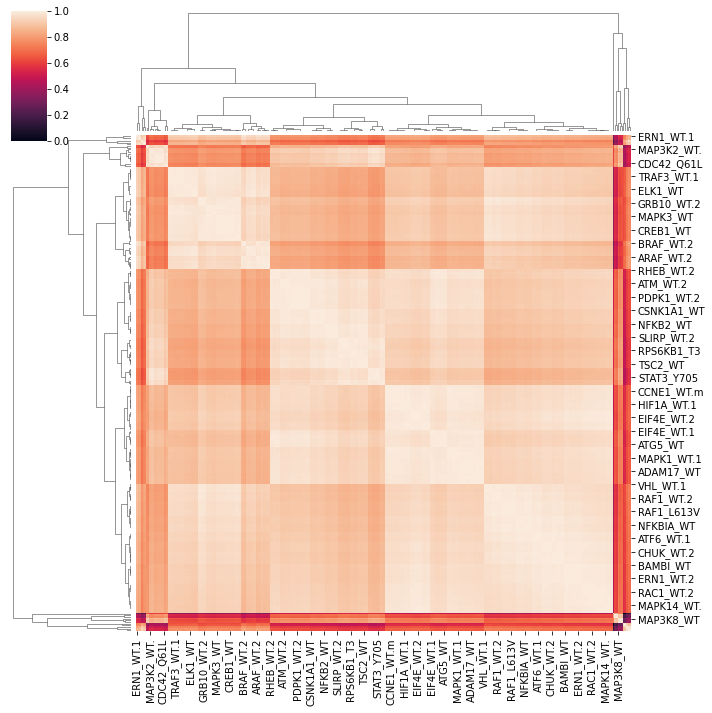

In [37]:
fig = plt.figure(figsize=[40,40])
ax = sns.clustermap(mean_shift_mtx)
plt.show()

Above we can visualize the dissimilarity of the mean of the histograms for the individual target using a heatmap which is clustered hierarchically for better visualization. Brighter colors indicate a higher similarity, darker ones a larger dissimilarity of the mean of the intensity profiles.

Next, we will look at the histograms of some of the most significantly different ones when comparing to the control setting. To this end we will use the average histogram and plot these over each other.

In [39]:
avg_profile_dict = get_average_profiles(profile_dict)

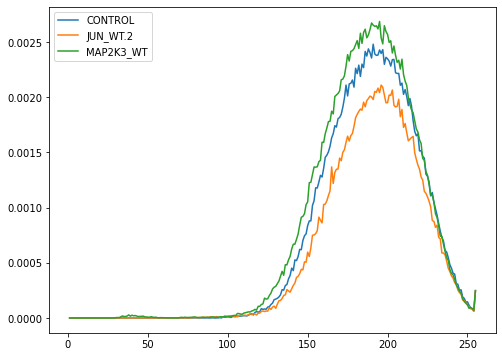

In [40]:
import matplotlib.lines as lines

fig = plt.figure(figsize=[8, 6])
plt.plot(list(range(1, 256)), avg_profile_dict["EMPTY_nan"][1:], label="CONTROL")
plt.plot(list(range(1, 256)), avg_profile_dict["JUN_WT.2"][1:], label="JUN_WT.2")
plt.plot(list(range(1, 256)), avg_profile_dict["MAP2K3_WT"][1:], label="MAP2K3_WT")
plt.legend()
plt.show()

In the above histogram you can see that actually for JUN, CDKN1A and ERG that the mode of the signal distribution is the same but the density at the mode is very different. This suggests, that for those conditions the size of nucleus seems to be the more discriminative feature than the distribution of the DNA condensation inside nucleus.

When comparing the control condition against HRAS we see that the density at the mode is different from the control condition (substantially higher) which suggests and increase in the nuclear size but as well as the distribution is shifted to the left for HRAS. The latter suggests that the DNA condensation is lower on average for HRAS treated ones when compared to the control setting.

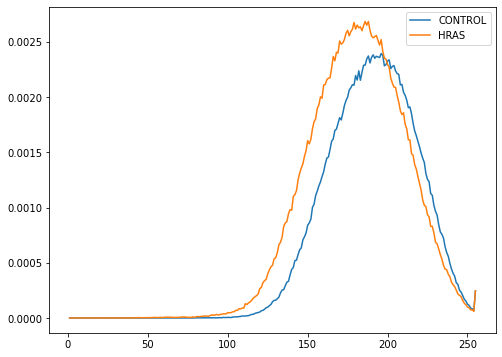

In [171]:
fig = plt.figure(figsize=[8, 6])
plt.plot(list(range(1, 256)), avg_profile_dict["EMPTY"][1:], label="CONTROL")
plt.plot(list(range(1,256)), avg_profile_dict["HRAS"][1:], label="HRAS")
plt.legend()
plt.show()

---

#### 2.2.2. Mode shift

To further look into the cases where the chromatin condensation inside the nucleus seems to be significantly different when perturbing the U2OS cells with some ORF construct compared to the negative control case, we will repeat the above analysis. Now however, we will screen for significantly different modes (excluding the one corresponding to the background) of the intensity profiles.

In [42]:
modeshift_screen_results, profile_mode_dict = run_modeshift_screen(profile_dict, test="t", control="EMPTY_nan")
modeshift_screen_results

,EMPTY_nan_mode,target_mode,p_value,fwer
BRAF_V600E,191.206667,178.463333,1.216917e-15,3.602075e-13
HRAS_G12V,191.206667,179.640000,2.320395e-13,6.868368e-11
CDC42_Q61L,191.206667,180.326667,1.150720e-09,3.406132e-07
RAF1_L613V,191.206667,183.113333,4.053288e-08,1.199773e-05
AKT1_E17K,191.206667,182.980000,4.982576e-07,1.474842e-04
RELB_WT,191.206667,184.196667,2.258268e-06,6.684475e-04
KRAS_G12V,191.206667,184.233333,8.183698e-06,2.422375e-03
MAP3K2_WT.,191.206667,183.450000,8.618237e-06,2.550998e-03
CASP8_WT.1,191.206667,184.900000,2.502986e-05,7.408838e-03
CDC42_T17N,191.206667,184.363333,2.632382e-05,7.791850e-03


In [43]:
sig_mds_results = modeshift_screen_results.loc[modeshift_screen_results["fwer"]<0.05]
sig_mds_results

,EMPTY_nan_mode,target_mode,p_value,fwer
BRAF_V600E,191.206667,178.463333,1.216917e-15,3.602075e-13
HRAS_G12V,191.206667,179.640000,2.320395e-13,6.868368e-11
CDC42_Q61L,191.206667,180.326667,1.150720e-09,3.406132e-07
RAF1_L613V,191.206667,183.113333,4.053288e-08,1.199773e-05
AKT1_E17K,191.206667,182.980000,4.982576e-07,1.474842e-04
RELB_WT,191.206667,184.196667,2.258268e-06,6.684475e-04
KRAS_G12V,191.206667,184.233333,8.183698e-06,2.422375e-03
MAP3K2_WT.,191.206667,183.450000,8.618237e-06,2.550998e-03
CASP8_WT.1,191.206667,184.900000,2.502986e-05,7.408838e-03
CDC42_T17N,191.206667,184.363333,2.632382e-05,7.791850e-03


The genes for which the overexpression led to the most significant change of the mode of the signal distribution of the single nuclei images are HRAS, MAP3K2 and RELB. For all of these the mode is lower than for the control condition suggesting a decrease of the HC/EC ratio when U2OS cells are treated with the respective ORF overexpression constructs.

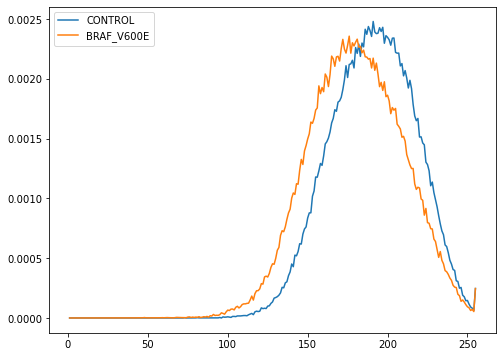

In [44]:
fig = plt.figure(figsize=[8, 6])
plt.plot(list(range(1, 256)), avg_profile_dict["EMPTY_nan"][1:], label="CONTROL")
plt.plot(list(range(1,256)), avg_profile_dict["BRAF_V600E"][1:], label="BRAF_V600E")
plt.legend()
plt.show()

As seen in the plot above the differences between the modes are not that large except for the HRAS case.

---

As a simple test of our modelling, we will train a classifier on separating between the control, the HRAS and ERG condition as their average intensity distributions are significantly different, we expect a model to be able to well distinguish between these conditions based on the single nuclei images.

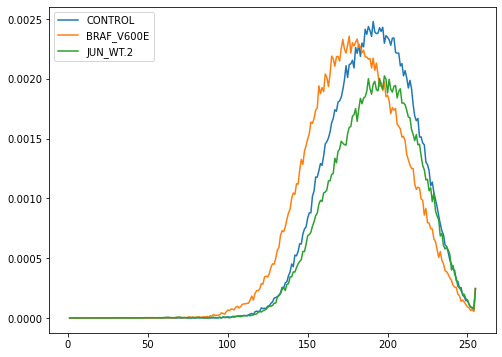

In [45]:
fig = plt.figure(figsize=[8, 6])
plt.plot(list(range(1, 256)), avg_profile_dict["EMPTY_nan"][1:], label="CONTROL")
plt.plot(list(range(1,256)), avg_profile_dict["BRAF_V600E"][1:], label="BRAF_V600E")
plt.plot(list(range(1,256)), avg_profile_dict["JUN_WT.1"][1:], label="JUN_WT.2")
plt.legend()
plt.show()